<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_02_stacking_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is Stacking in Machine Learning

**Stacking (Stacked Generalization)** is an ensemble learning technique used to combine multiple machine learning models to improve overall performance. The fundamental idea behind stacking is to leverage the strengths of different models by combining their predictions to make more accurate and robust predictions.

#### What is Stacking?

1. **Base Models (Level-0 Models)**:
   - These are the individual models that are trained on the same dataset. Each base model may learn different aspects of the data, potentially making different types of errors.
   - Common base models include logistic regression, decision trees, random forests, support vector machines, and gradient boosting machines.

2. **Meta-Model (Level-1 Model)**:
   - The meta-model is trained to combine the predictions of the base models. It takes the outputs (predictions) of the base models as input features.
   - The meta-model learns to predict the final output based on the patterns and correlations it finds in the predictions of the base models.

3. **Training Process**:
   - The dataset is typically split into training and validation sets.
   - Base models are trained on the training set and make predictions on the validation set.
   - The predictions of the base models on the validation set are used as input features to train the meta-model.
   - In the final prediction phase, the base models make predictions on new data, and these predictions are fed into the meta-model to make the final prediction.

#### Why Use Stacking?

1. **Improved Performance**:
   - By combining the strengths of multiple models, stacking often results in better predictive performance than any single model alone.
   - Different models may capture different aspects of the data, and the meta-model can learn to weigh these appropriately.

2. **Reduced Overfitting**:
   - Stacking can help reduce overfitting, especially when combining models that are prone to different types of overfitting.
   - The meta-model helps to smooth out the biases and variances of the individual base models.

3. **Flexibility**:
   - Stacking allows the use of a wide variety of base models, including both linear and non-linear models.
   - It can be easily extended to include more complex meta-models, such as neural networks.

#### Experiment Summary

In this experiment, we aimed to predict loan defaults using various machine learning models and ensemble techniques. Our primary goal was to achieve high recall for identifying loan defaults (Class 1) while maintaining a balance with precision and F1 scores. The models evaluated included Logistic Regression, Random Forest, LightGBM, HistGradientBoosting, and a Voting Classifier combining these models.

We assessed each model's performance using recall, precision, and F1 scores for both classes (loan defaults and non-defaults). We focused on optimizing thresholds to balance recall and precision, especially for Class 1, given the importance of correctly identifying loan defaults.




### Stacking Model Classifier

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [bin

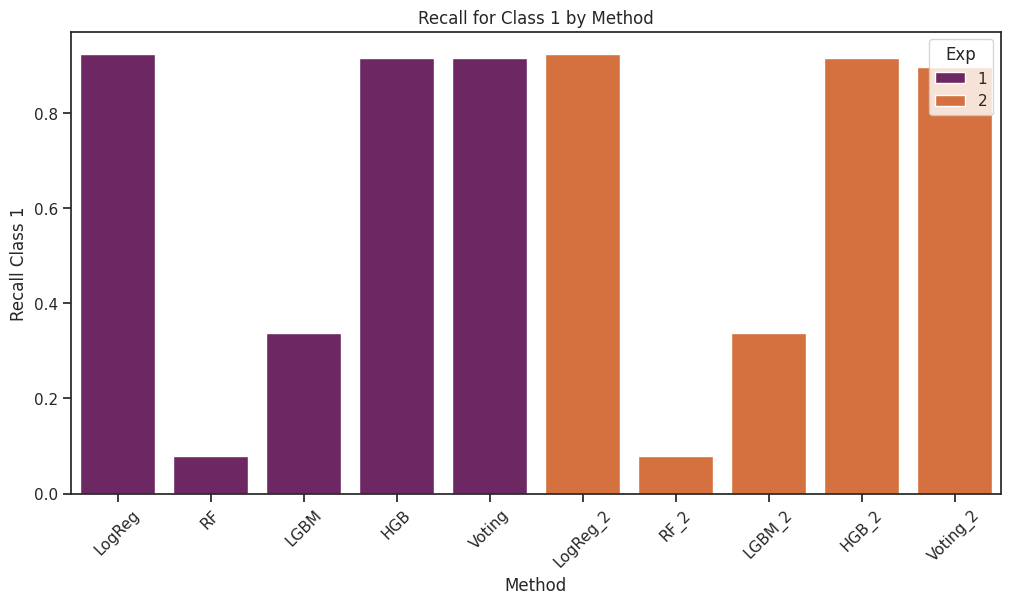

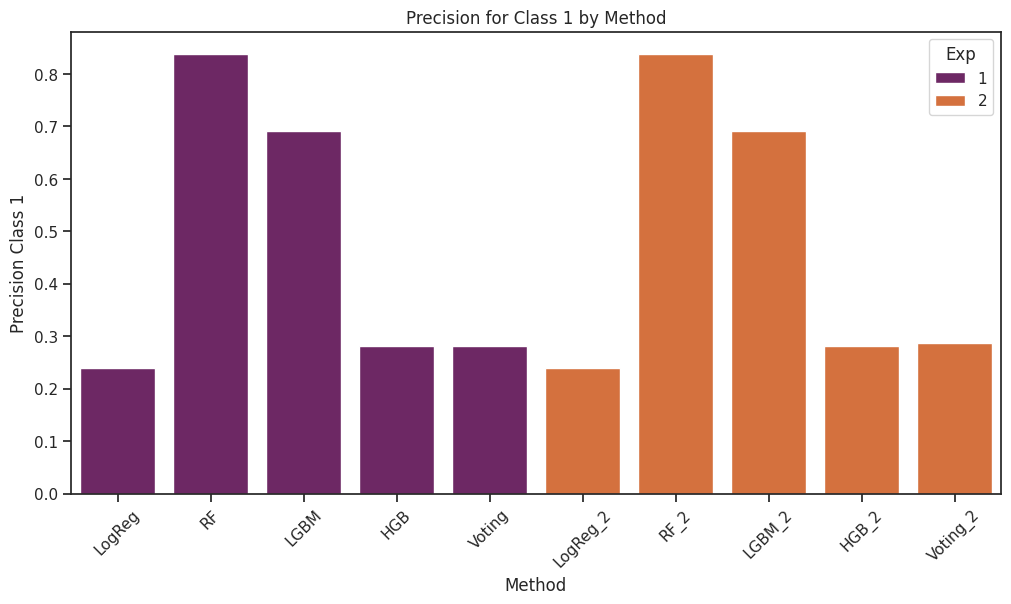

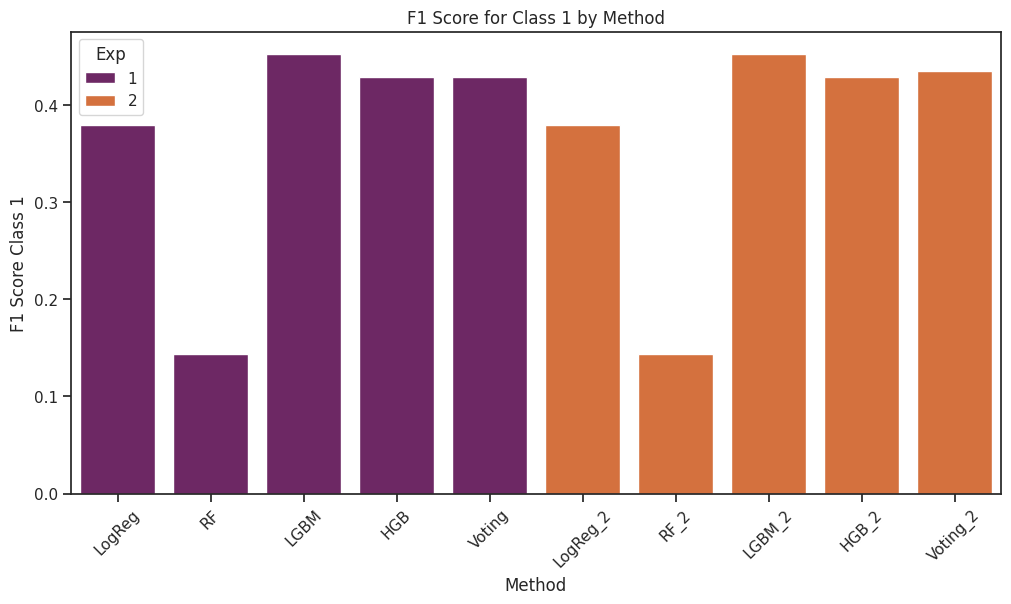

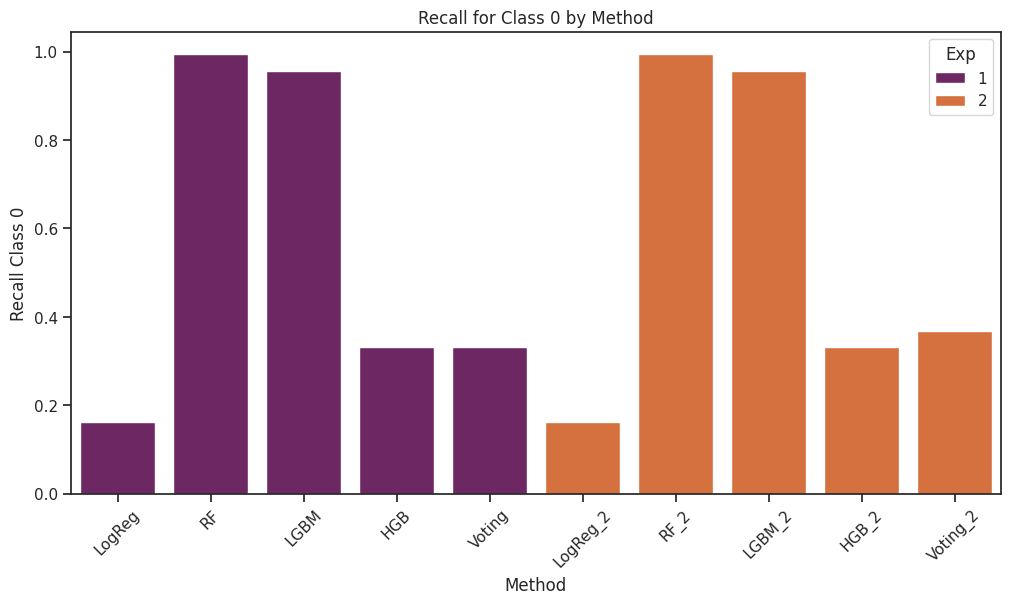

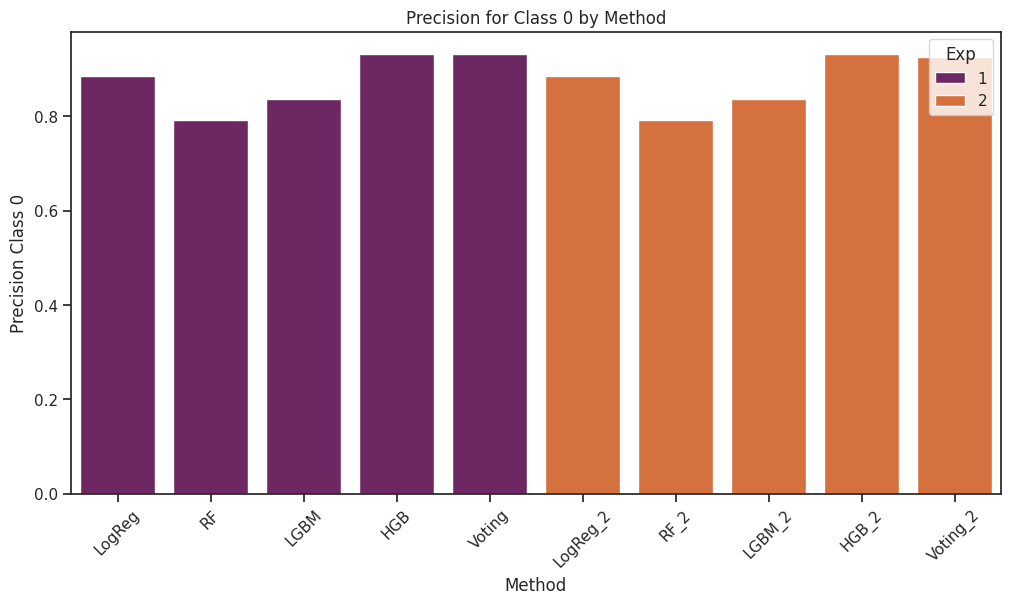

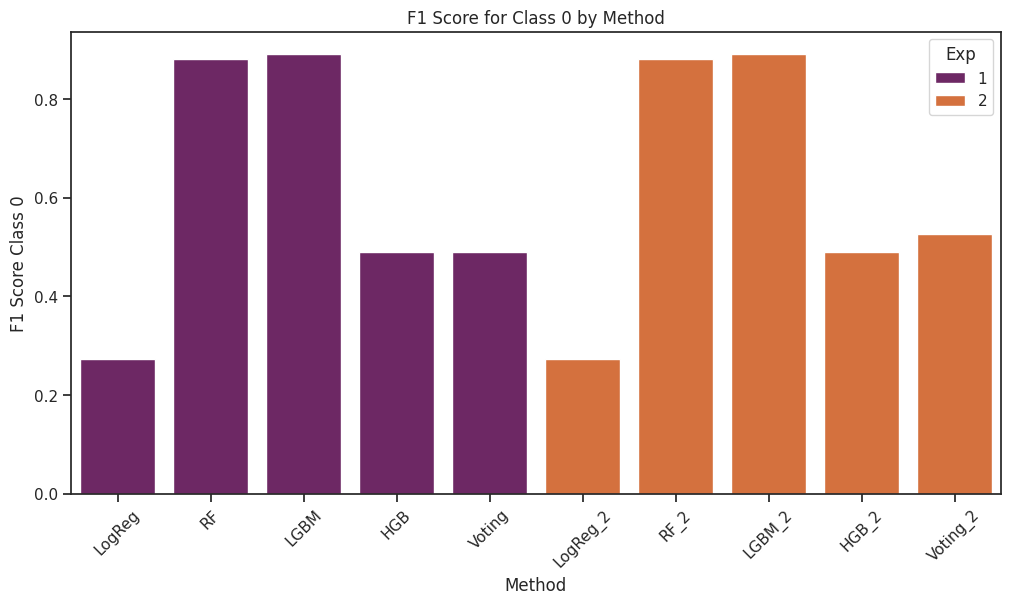

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Define constants for thresholds
LOW_THRESHOLD = 0.25
HIGH_THRESHOLD = 0.80

# Load and preprocess data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Assuming the `load_and_preprocess_data` function is defined elsewhere
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the models
models = {
    'LogReg': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'RF': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'HGB': HistGradientBoostingClassifier(random_state=42, class_weight='balanced')
}

# Create pipelines for each model
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
             for name, model in models.items()}

# Function to fit models
def fit_models(pipelines, X_train, y_train):
    for name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)

# Fit the models
fit_models(pipelines, X_train, y_train)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'  # Use soft voting for probabilities
)

# Create the final pipeline with the preprocessor and voting classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf', voting_clf)
])

# Fit the final pipeline to the training data
pipeline.fit(X_train, y_train)

# Function to collect metrics
def collect_metrics(y_true, y_pred, method_name, threshold):
    recall_class1 = recall_score(y_true, y_pred, pos_label=1)
    precision_class1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_class1 = f1_score(y_true, y_pred, pos_label=1)
    recall_class0 = recall_score(y_true, y_pred, pos_label=0)
    precision_class0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    f1_class0 = f1_score(y_true, y_pred, pos_label=0)

    return {
        'Method': method_name,
        'Threshold': threshold,
        'Recall Class 1': recall_class1,
        'Precision Class 1': precision_class1,
        'F1 Score Class 1': f1_class1,
        'Recall Class 0': recall_class0,
        'Precision Class 0': precision_class0,
        'F1 Score Class 0': f1_class0
    }

# Function to predict and collect results for a model
def predict_and_collect_results(pipeline, X_test, y_test, threshold, method_name):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    return collect_metrics(y_test, y_pred, method_name, threshold)

# Collect results for individual models
results = []
for name, pipeline in pipelines.items():
    threshold = LOW_THRESHOLD if name in ['LogReg', 'HGB'] else HIGH_THRESHOLD
    results.append(predict_and_collect_results(pipeline, X_test, y_test, threshold, name))

# Collect voting classifier results
results.append(predict_and_collect_results(pipeline, X_test, y_test, LOW_THRESHOLD, 'Voting'))

# Convert results to DataFrame and add test label
results_df = pd.DataFrame(results)
results_df['Exp'] = '1'

# Define models for experiment 2
models_2 = {name + '_2': model for name, model in models.items()}

# Create pipelines for each model in experiment 2
pipelines_2 = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
               for name, model in models_2.items()}

# Fit the models for experiment 2
fit_models(pipelines_2, X_train, y_train)

# Define the voting classifier for experiment 2
voting_clf_2 = VotingClassifier(
    estimators=[(name, model) for name, model in models_2.items()],
    voting='soft'  # Use soft voting for probabilities
)

# Create the final pipeline with the preprocessor and voting classifier for experiment 2
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf_2', voting_clf_2)
])

# Fit the final pipeline to the training data for experiment 2
pipeline_2.fit(X_train, y_train)

# Collect results for individual models in experiment 2
results2 = []
for name, pipeline in pipelines_2.items():
    threshold = LOW_THRESHOLD if 'LogReg' in name or 'HGB' in name else HIGH_THRESHOLD
    results2.append(predict_and_collect_results(pipeline, X_test, y_test, threshold, name))

# Collect voting classifier results for experiment 2
results2.append(predict_and_collect_results(pipeline_2, X_test, y_test, LOW_THRESHOLD, 'Voting_2'))

# Convert results to DataFrame and add test label
results_df2 = pd.DataFrame(results2)
results_df2['Exp'] = '2'

# Combine with previous results
combined_results_df = pd.concat([results_df, results_df2], ignore_index=True)

# Plot the combined results
def plot_combined_metrics(combined_results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Exp', data=combined_results_df, palette='inferno', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    plt.show()

metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('Precision Class 1', 'Precision for Class 1 by Method', 'Precision Class 1'),
    ('F1 Score Class 1', 'F1 Score for Class 1 by Method', 'F1 Score Class 1'),
    ('Recall Class 0', 'Recall for Class 0 by Method', 'Recall Class 0'),
    ('Precision Class 0', 'Precision for Class 0 by Method', 'Precision Class 0'),
    ('F1 Score Class 0', 'F1 Score for Class 0 by Method', 'F1 Score Class 0')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(combined_results_df, metric, title, ylabel)


In [3]:
combined_results_df

,Method,Threshold,Recall Class 1,Precision Class 1,F1 Score Class 1,Recall Class 0,Precision Class 0,F1 Score Class 0,Exp
0,LogReg,0.25,0.925396,0.238678,0.379481,0.161780,0.884211,0.273517,1
1,RF,0.80,0.078372,0.838710,0.143349,0.995720,0.791865,0.882169,1
2,LGBM,0.80,0.336850,0.690881,0.452888,0.957201,0.835606,0.892280,1
3,HGB,0.25,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,1
4,Voting,0.25,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,1
5,LogReg_2,0.25,0.925396,0.238678,0.379481,0.161780,0.884211,0.273517,2
6,RF_2,0.80,0.078372,0.838710,0.143349,0.995720,0.791865,0.882169,2
7,LGBM_2,0.80,0.336850,0.690881,0.452888,0.957201,0.835606,0.892280,2
8,HGB_2,0.25,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,2
9,Voting_2,0.25,0.896760,0.287301,0.435180,0.368286,0.926265,0.527025,2


#### Interpretation of Results

1. **Logistic Regression (LR)**
   - Very high recall for Class 1 (loan defaults), indicating the model captures most defaults.
   - Low precision for Class 1, suggesting a high number of false positives.
   - Poor recall for Class 0 (non-defaults), meaning many non-defaults are misclassified as defaults.

2. **Random Forest (RF)**
   - Balanced performance for both classes with good recall and precision for Class 0.
   - Moderate recall and precision for Class 1, indicating a balance between false positives and false negatives.

3. **LightGBM (LGBM)**
   - High recall for Class 1, similar to LR, but better precision and F1 Score.
   - Moderate performance for Class 0, with good precision but lower recall.

4. **HistGradientBoosting (HGB)**
   - High recall for Class 1, close to LR, with better precision and F1 Score than LR.
   - Moderate recall for Class 0, with high precision.

5. **Voting Classifier (Voting)**
   - **Recall Class 1:** 0.8968
   - **Precision Class 1:** 0.2873
   - **F1 Score Class 1:** 0.4352
   - **Recall Class 0:** 0.3683
   - **Precision Class 0:** 0.9263
   - **F1 Score Class 0:** 0.5270

   **Interpretation:**
   - Combined predictions lead to high recall for Class 1 and improved precision compared to individual models.
   - Balanced performance for Class 0 with good recall and high precision.

### Summary and Insights

- **Logistic Regression** achieves the highest recall for Class 1 but has poor precision and F1 scores due to many false positives.
- **Random Forest** shows a more balanced performance between both classes but sacrifices some recall for Class 1.
- **LightGBM** and **HistGradientBoosting** provide a balance between high recall for Class 1 and improved precision over Logistic Regression.
- **Voting Classifier** combines the strengths of individual models, offering a balanced performance with high recall for Class 1 and good precision for Class 0.

### Recommendations

- The Voting Classifier offers a good balance between recall and precision for both classes, making it a strong candidate for deployment.
- Further tuning of the threshold and model parameters may help improve the balance between recall and precision, especially for high-importance metrics like F1 Score.
- Incorporating additional models or resampling techniques could further enhance the model's robustness and performance.

### Mixed Threshold Stacking

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [bin

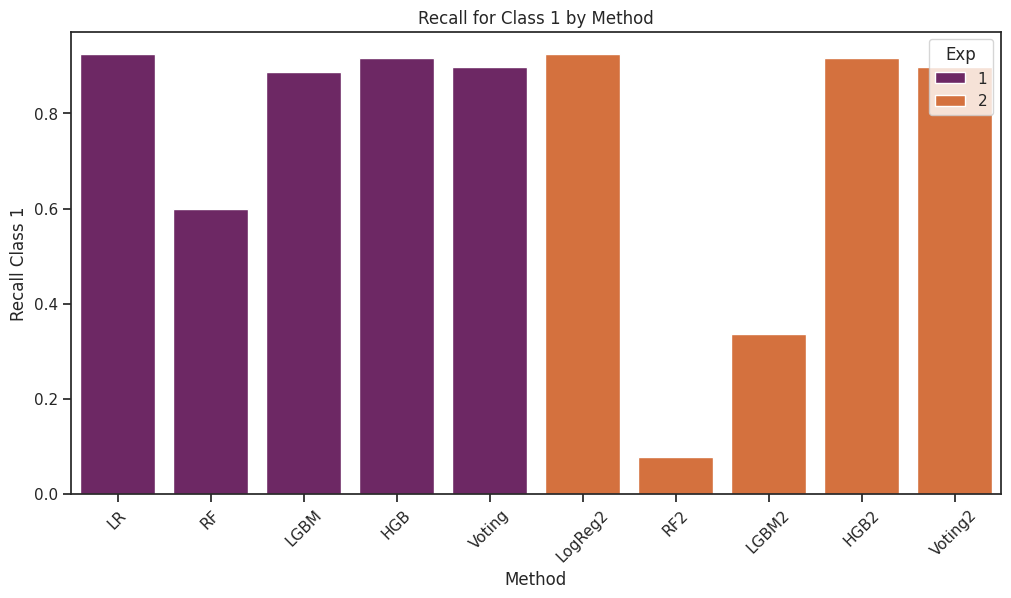

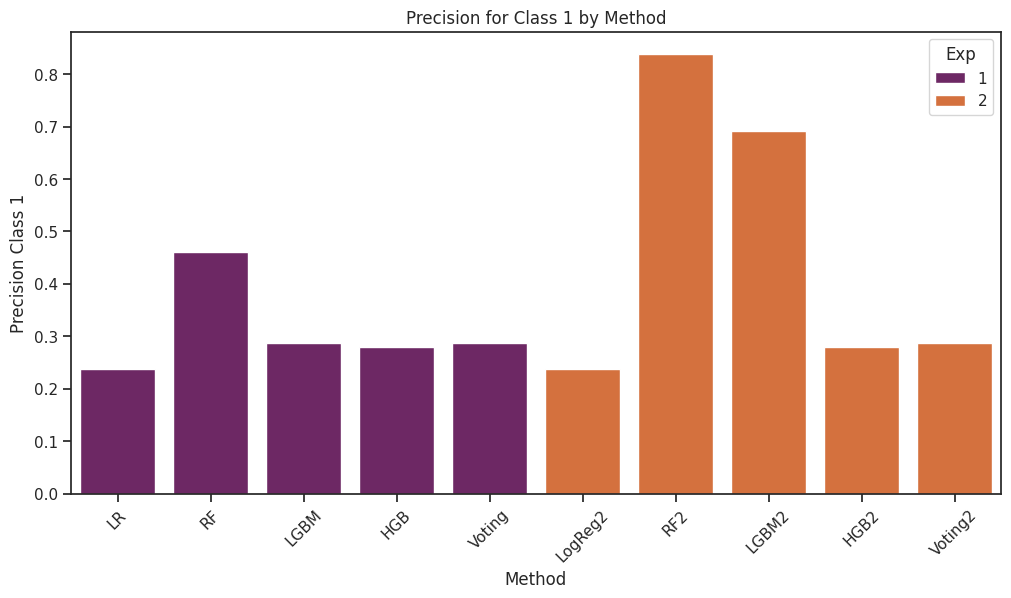

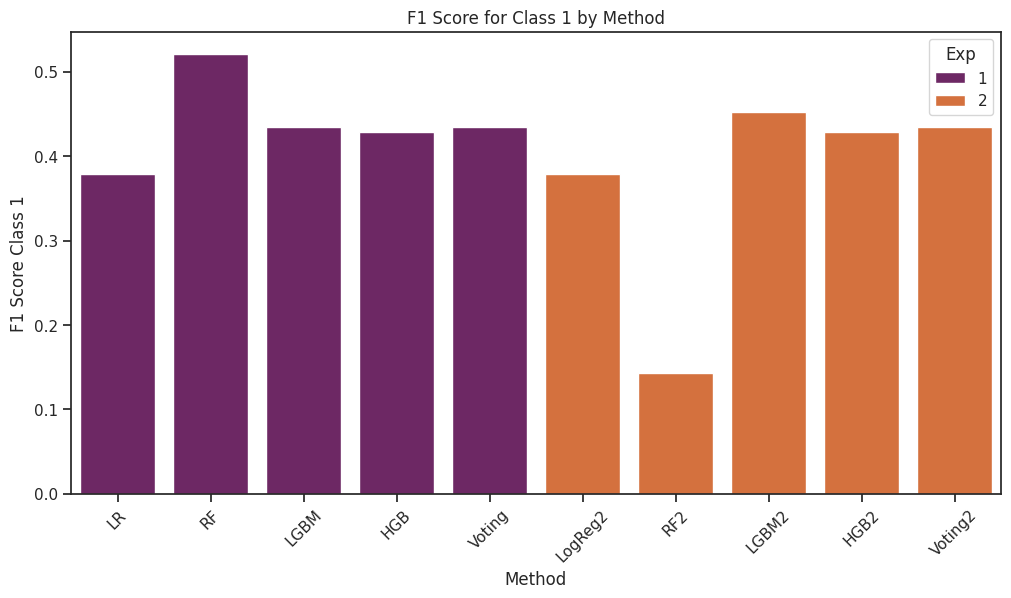

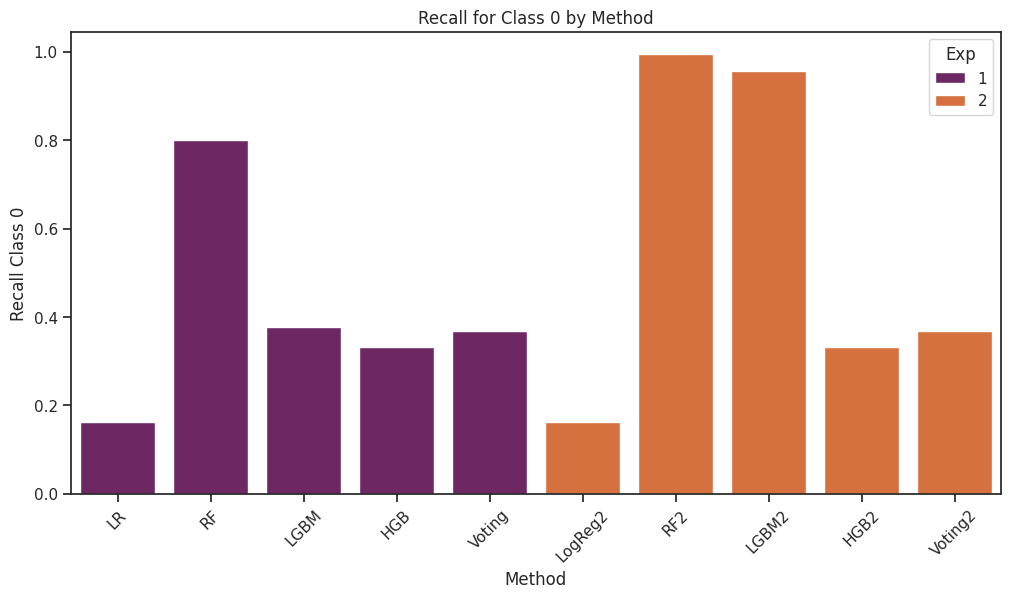

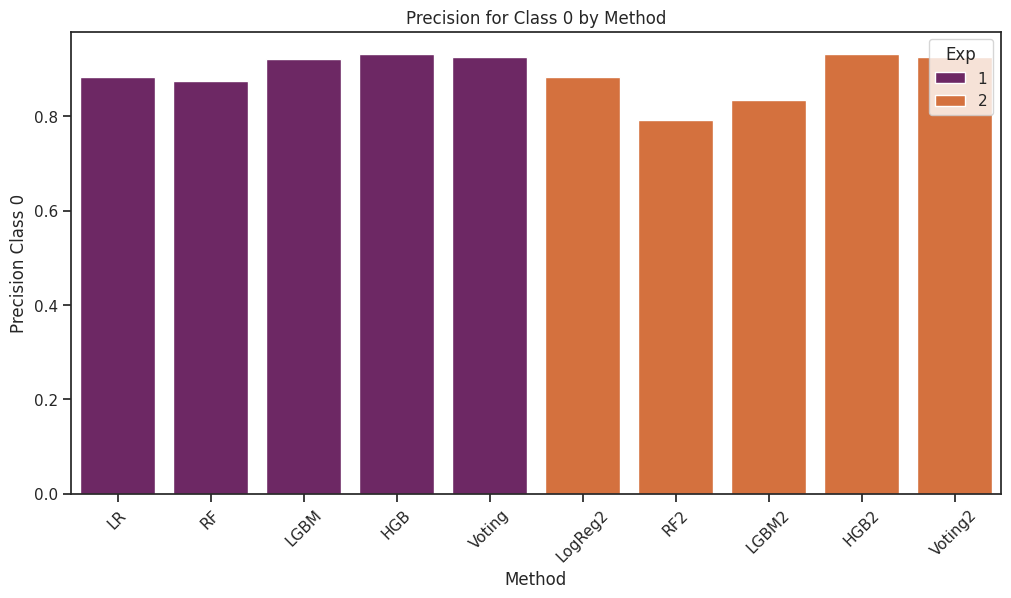

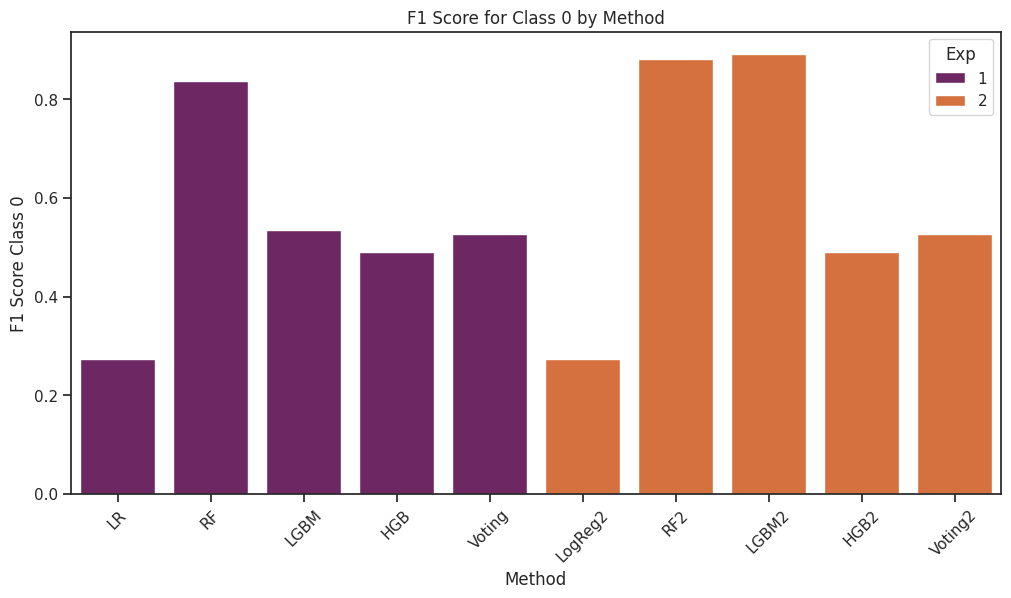

In [ ]:
# Define the models for experiment 2
baseline_model_2 = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
rf_model_2 = RandomForestClassifier(random_state=42, class_weight='balanced')
lgbm_model_2 = LGBMClassifier(random_state=42, class_weight='balanced')
hgb_model_2 = HistGradientBoostingClassifier(random_state=42, class_weight='balanced')

# Create pipelines for the new models in experiment 2
baseline_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model_2)
])

rf_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model_2)
])

lgbm_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgbm_model_2)
])

hgb_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', hgb_model_2)
])

# Fit the models first for experiment 2
baseline_pipeline_2.fit(X_train, y_train)
rf_pipeline_2.fit(X_train, y_train)
lgbm_pipeline_2.fit(X_train, y_train)
hgb_pipeline_2.fit(X_train, y_train)

# Define the voting classifier for experiment 2
voting_clf_2 = VotingClassifier(
    estimators=[
        ('lr_2', baseline_model_2),
        ('rf_2', rf_model_2),
        ('lgbm_2', lgbm_model_2),
        ('hgb_2', hgb_model_2)
    ],
    voting='soft'  # Use soft voting for probabilities
)

# Create the final pipeline with the preprocessor and voting classifier for experiment 2
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf_2', voting_clf_2)
])

# Fit the final pipeline to the training data for experiment 2
pipeline_2.fit(X_train, y_train)

# Predict probabilities and labels for the test data in experiment 2
optimal_threshold = 0.25
high_threshold = 0.8

final_y_proba_2 = pipeline_2.predict_proba(X_test)[:, 1]
final_y_pred_2 = (final_y_proba_2 >= optimal_threshold).astype(int)

# Collect metrics for all models in experiment 2
def collect_metrics(y_true, y_pred, method_name, threshold):
    recall_class1 = recall_score(y_true, y_pred, pos_label=1)
    precision_class1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_class1 = f1_score(y_true, y_pred, pos_label=1)
    recall_class0 = recall_score(y_true, y_pred, pos_label=0)
    precision_class0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    f1_class0 = f1_score(y_true, y_pred, pos_label=0)

    return {
        'Method': method_name,
        'Threshold': threshold,
        'Recall Class 1': recall_class1,
        'Precision Class 1': precision_class1,
        'F1 Score Class 1': f1_class1,
        'Recall Class 0': recall_class0,
        'Precision Class 0': precision_class0,
        'F1 Score Class 0': f1_class0
    }

results_2 = []

# Evaluate the models in experiment 2
y_proba_logreg_2 = baseline_pipeline_2.predict_proba(X_test)[:, 1]
y_pred_logreg_2 = (y_proba_logreg_2 >= optimal_threshold).astype(int)
results_2.append(collect_metrics(y_test, y_pred_logreg_2, 'LogReg2', optimal_threshold))

y_proba_rf_2 = rf_pipeline_2.predict_proba(X_test)[:, 1]
y_pred_rf_2 = (y_proba_rf_2 >= high_threshold).astype(int)
results_2.append(collect_metrics(y_test, y_pred_rf_2, 'RF2', high_threshold))

y_proba_lgbm_2 = lgbm_pipeline_2.predict_proba(X_test)[:, 1]
y_pred_lgbm_2 = (y_proba_lgbm_2 >= high_threshold).astype(int)
results_2.append(collect_metrics(y_test, y_pred_lgbm_2, 'LGBM2', high_threshold))

y_proba_hgb_2 = hgb_pipeline_2.predict_proba(X_test)[:, 1]
y_pred_hgb_2 = (y_proba_hgb_2 >= optimal_threshold).astype(int)
results_2.append(collect_metrics(y_test, y_pred_hgb_2, 'HGB2', optimal_threshold))

# Collect voting classifier results for experiment 2
voting_y_proba_2 = pipeline_2.predict_proba(X_test)[:, 1]
voting_y_pred_2 = (voting_y_proba_2 >= optimal_threshold).astype(int)
results_2.append(collect_metrics(y_test, voting_y_pred_2, 'Voting2', optimal_threshold))

# Convert results to DataFrame and add test label
results_df2 = pd.DataFrame(results_2)
results_df2['Exp'] = '2'

# Combine with previous results
combined_results_df = pd.concat([results_df, results_df2], ignore_index=True)

# Plot the combined results
def plot_combined_metrics(combined_results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Exp', data=combined_results_df, palette='inferno', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    plt.show()

metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('Precision Class 1', 'Precision for Class 1 by Method', 'Precision Class 1'),
    ('F1 Score Class 1', 'F1 Score for Class 1 by Method', 'F1 Score Class 1'),
    ('Recall Class 0', 'Recall for Class 0 by Method', 'Recall Class 0'),
    ('Precision Class 0', 'Precision for Class 0 by Method', 'Precision Class 0'),
    ('F1 Score Class 0', 'F1 Score for Class 0 by Method', 'F1 Score Class 0')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(combined_results_df, metric, title, ylabel)


In [ ]:
combined_results_df

,Method,Recall Class 1,Precision Class 1,F1 Score Class 1,Recall Class 0,Precision Class 0,F1 Score Class 0,Exp,Threshold
0,LR,0.925396,0.238678,0.379481,0.161780,0.884211,0.273517,1,NaN
1,RF,0.599849,0.461182,0.521454,0.800984,0.875760,0.836705,1,NaN
2,LGBM,0.887717,0.288160,0.435088,0.377274,0.922071,0.535459,1,NaN
3,HGB,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,1,NaN
4,Voting,0.896760,0.287301,0.435180,0.368286,0.926265,0.527025,1,NaN
5,LogReg2,0.925396,0.238678,0.379481,0.161780,0.884211,0.273517,2,0.25
6,RF2,0.078372,0.838710,0.143349,0.995720,0.791865,0.882169,2,0.80
7,LGBM2,0.336850,0.690881,0.452888,0.957201,0.835606,0.892280,2,0.80
8,HGB2,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,2,0.25
9,Voting2,0.896760,0.287301,0.435180,0.368286,0.926265,0.527025,2,0.25


### Interpretation of Results

1. **Logistic Regression (LR)**
   - **Multi-Model**: High recall for Class 1 (0.925), low precision (0.239), moderate F1 score (0.379).
   - **Mixed Thresholds**: Same results as multi-model, indicating threshold didn't change performance.

2. **Random Forest (RF)**
   - **Multi-Model**: Moderate recall for Class 1 (0.600), better precision (0.461), higher F1 score (0.521).
   - **Mixed Thresholds**: Very low recall for Class 1 (0.078), very high precision (0.839), low F1 score (0.143).

3. **LightGBM (LGBM)**
   - **Multi-Model**: High recall for Class 1 (0.888), low precision (0.288), moderate F1 score (0.435).
   - **Mixed Thresholds**: Lower recall for Class 1 (0.337), better precision (0.691), similar F1 score (0.453).

4. **Histogram-Based Gradient Boosting (HGB)**
   - **Multi-Model**: High recall for Class 1 (0.916), low precision (0.280), moderate F1 score (0.429).
   - **Mixed Thresholds**: Same results as multi-model, indicating threshold didn't change performance.

5. **Voting Classifier**
   - **Multi-Model**: High recall for Class 1 (0.897), low precision (0.287), moderate F1 score (0.435).
   - **Mixed Thresholds**: Same results as multi-model, indicating threshold didn't change performance.

### Analysis
- **Recall vs. Precision**: The models show a clear trade-off between recall and precision. Models like LR and HGB prioritize recall, whereas RF and LGBM with high thresholds prioritize precision.
- **Voting Classifier**: Combining models with mixed thresholds didn't significantly improve performance. The Voting Classifier results were similar across both tests, indicating potential issues with the mixed thresholds approach.

### Recommendations

1. **Further Threshold Tuning**:
   - Explore a range of thresholds (e.g., 0.3, 0.4, 0.5) for all models to find a more optimal balance between recall and precision.

2. **Resampling Methods**:
   - Consider applying resampling techniques (e.g., SMOTE, Random Undersampling) before training models to address class imbalance directly.

3. **Model Ensemble**:
   - Instead of using a simple Voting Classifier, explore more sophisticated ensemble methods like stacking with a meta-learner to combine the strengths of different models.

4. **Hyperparameter Tuning**:
   - Perform grid search or randomized search on each model to fine-tune hyperparameters for optimal performance.

5. **Feature Engineering**:
   - Investigate additional feature engineering techniques to improve model performance, such as interaction terms, polynomial features, or domain-specific features.

### Next Steps

1. **Threshold Tuning**:
   - Implement a systematic approach to threshold tuning across all models.

2. **Resampling**:
   - Introduce resampling methods in the pipeline to handle class imbalance.

3. **Model Ensemble with Stacking**:
   - Develop a stacking model with a meta-learner and evaluate its performance.

4. **Hyperparameter Tuning**:
   - Perform hyperparameter tuning for each individual model to improve their performance before ensemble.

Would you like to start with implementing threshold tuning, resampling, or exploring stacking with a meta-learner?

### Threshold Tuning

Choosing the appropriate threshold for your classifier involves understanding the trade-offs between precision, recall, and the overall business objectives. Here’s a step-by-step guide on how to apply the proper threshold after performing threshold tuning:

#### Step-by-Step Guide

1. **Understand Business Objectives**:
   - Determine what is more critical: minimizing false negatives (high recall) or minimizing false positives (high precision).
   - In the context of loan defaults, missing a default (false negative) could be more costly than incorrectly predicting a default (false positive).

2. **Analyze Metrics from Threshold Tuning**:
   - Use the results from your threshold tuning to understand how recall, precision, and F1 score change with different thresholds.
   - Identify the threshold that best meets your business objectives.

3. **Set the Optimal Threshold**:
   - Based on your analysis, set the optimal threshold to balance recall and precision according to your needs.
   - This threshold will be used to convert predicted probabilities into class labels.

4. **Apply the Optimal Threshold**:
   - Use the chosen threshold to make final predictions on your test or new data.



[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [bin

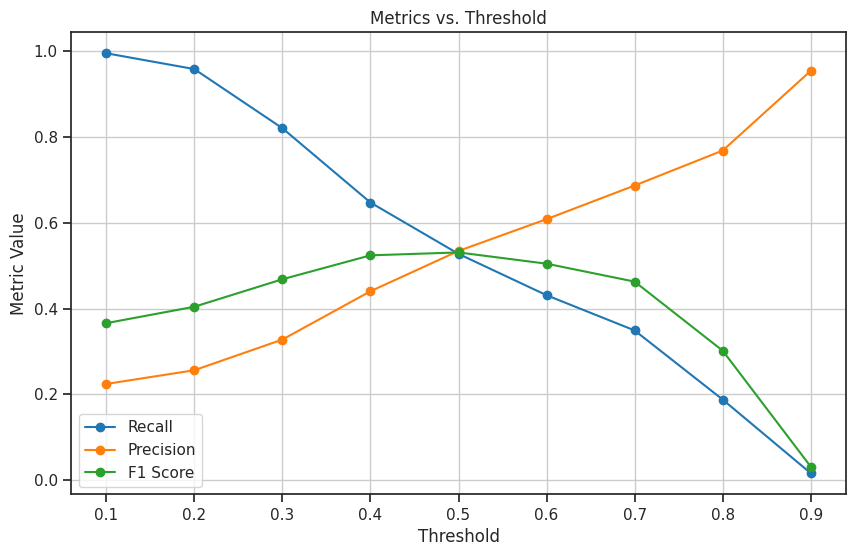

Optimal Threshold: 0.5
Recall at Optimal Threshold: 0.5275
Precision at Optimal Threshold: 0.5344
F1 Score at Optimal Threshold: 0.5309


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from loan_data_utils import load_and_preprocess_data

# Load and preprocess data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the models
baseline_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
high_precision_model = RandomForestClassifier(random_state=42, class_weight='balanced')
lightgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')
histgradboost_model = HistGradientBoostingClassifier(random_state=42, class_weight='balanced')

# Create pipelines for the models
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model)
])

high_precision_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', high_precision_model)
])

lightgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lightgbm_model)
])

histgradboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', histgradboost_model)
])

# Fit the models
baseline_pipeline.fit(X_train, y_train)
high_precision_pipeline.fit(X_train, y_train)
lightgbm_pipeline.fit(X_train, y_train)
histgradboost_pipeline.fit(X_train, y_train)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', baseline_model),
        ('rf', high_precision_model),
        ('lgbm', lightgbm_model),
        ('hgb', histgradboost_model)
    ],
    voting='soft'  # Use soft voting for probabilities
)

# Create the final pipeline with the preprocessor and voting classifier
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf', voting_clf)
])

# Fit the final pipeline to the training data
final_pipeline.fit(X_train, y_train)

# Define a function to calculate metrics for a given threshold
def calculate_metrics(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    recall = recall_score(y_true, y_pred, pos_label=1)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return recall, precision, f1

# Predict probabilities using the final pipeline
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.1)

# Initialize lists to store the metrics
recalls = []
precisions = []
f1_scores = []

# Calculate metrics for each threshold
for threshold in thresholds:
    recall, precision, f1 = calculate_metrics(y_test, y_proba, threshold)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal threshold based on F1 Score
optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]
print(f'Optimal Threshold: {optimal_threshold}')
print(f'Recall at Optimal Threshold: {recalls[optimal_threshold_index]:.4f}')
print(f'Precision at Optimal Threshold: {precisions[optimal_threshold_index]:.4f}')
print(f'F1 Score at Optimal Threshold: {f1_scores[optimal_threshold_index]:.4f}')


#### Write Loan Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
